# Spaceship Titanic - Notebook

<!-- TODO -->


Import the necessary libraries. We will use:

- `pandas` to load the data and manipulate it.
- `scikit-learn` to build the model.
<!-- TODO - `matplotlib` and `seaborn` to plot the data. -->


In [2]:
import os
import json
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    f_classif,
    mutual_info_classif,
    RFE,
)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from featuretools import EntitySet, dfs

import optuna
from optuna.samplers import TPESampler, GridSampler

import signal

/home/javier/.cache/pypoetry/virtualenvs/spaceship-titanic-UUL0AmCy-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define constants
CURRENT_DIR = os.getcwd()

DATA_DIR = f"{CURRENT_DIR}/data"
TRAIN_DATA_FILE = f"{DATA_DIR}/train.csv"
TEST_DATA_FILE = f"{DATA_DIR}/test.csv"

TARGET_COLUMN = "Transported"
ID_COLUMN = "PassengerId"

RANDOM_SEED = 42
VALIDATION_SIZE = 0.2

MISSING_VALUE = "Missing"

In [4]:
# Load the data files into pandas dataframes
train_data = pd.read_csv(TRAIN_DATA_FILE)
test_data = pd.read_csv(TEST_DATA_FILE)

## Data Exploration


In [5]:
print("First few rows of data:")
display(train_data.head())

First few rows of data:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
print("Data columns and types:")
print(train_data.dtypes)

Data columns and types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [7]:
NUMERICAL_COLUMNS = train_data.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_COLUMNS = train_data.select_dtypes(include=["object"]).columns.tolist()


leftover_columns = [
    col
    for col in train_data.columns
    if col not in NUMERICAL_COLUMNS
    and col not in CATEGORICAL_COLUMNS
    and col != TARGET_COLUMN
]
assert not leftover_columns

In [8]:
print(f"Numerical columns: {NUMERICAL_COLUMNS}")
print(f"Categorical columns: {CATEGORICAL_COLUMNS}")
print(f"Target column: {TARGET_COLUMN}")

Numerical columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
Categorical columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
Target column: Transported


<Figure size 1000x600 with 0 Axes>

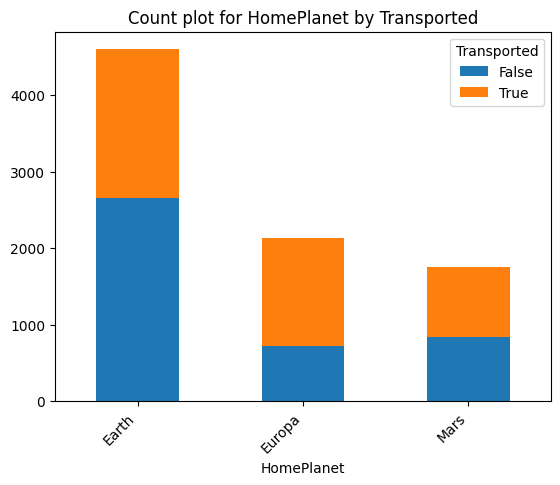

<Figure size 1000x600 with 0 Axes>

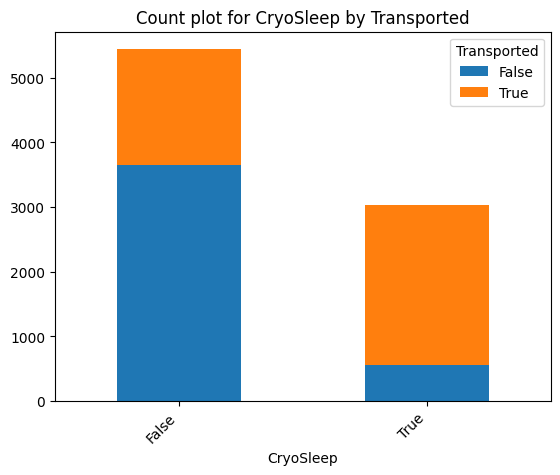

<Figure size 1000x600 with 0 Axes>

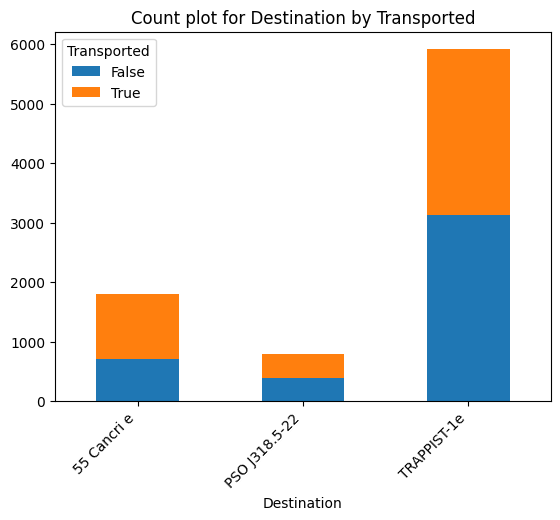

<Figure size 1000x600 with 0 Axes>

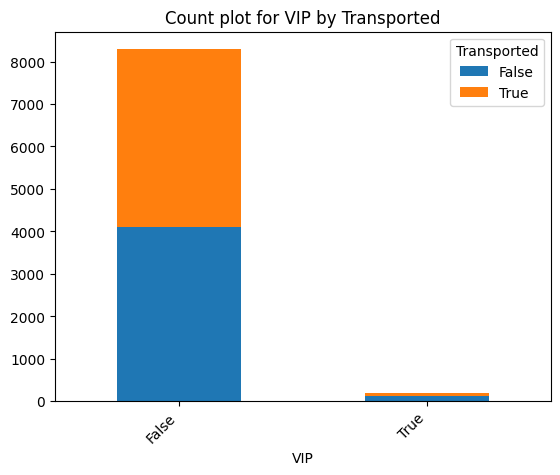

In [9]:
categorical_columns = CATEGORICAL_COLUMNS.copy()
categorical_columns.remove(ID_COLUMN)
categorical_columns.remove("Cabin")
categorical_columns.remove("Name")

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    train_data.groupby([col, TARGET_COLUMN]).size().unstack().plot(
        kind="bar", stacked=True
    )
    plt.title(f"Count plot for {col} by {TARGET_COLUMN}")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    plt.close()

<Figure size 1000x600 with 0 Axes>

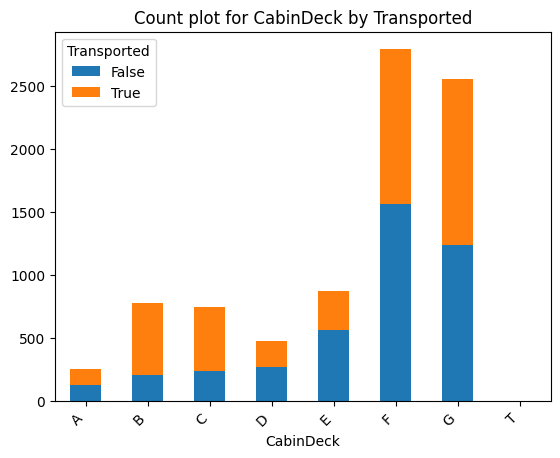

<Figure size 1000x600 with 0 Axes>

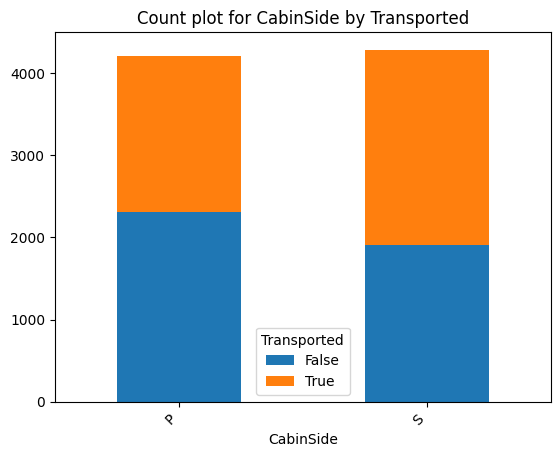

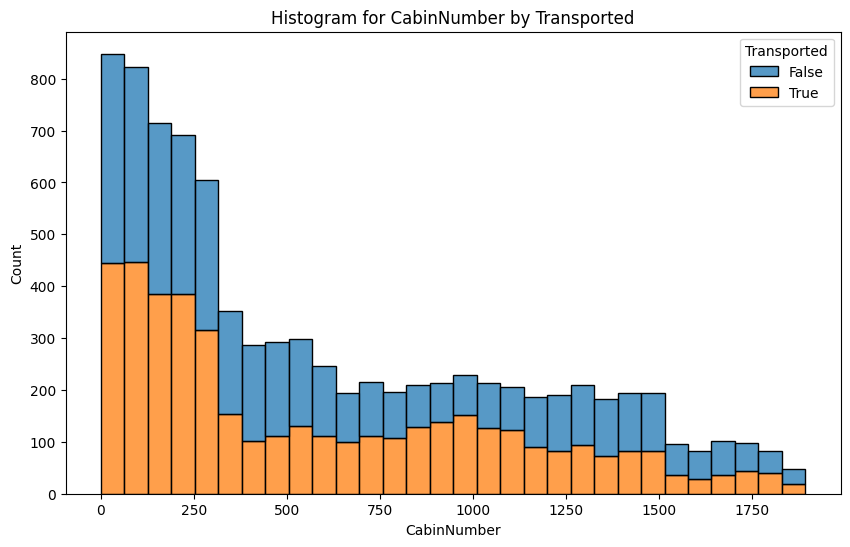

In [10]:
# Split the Cabin column into CabinDeck, CabinNumber, and CabinSide
train_data[['CabinDeck', 'CabinNumber', 'CabinSide']] = train_data['Cabin'].str.split('/', expand=True)

# Convert CabinNumber to a numerical type
train_data['CabinNumber'] = pd.to_numeric(train_data['CabinNumber'], errors='coerce').astype("Int64")

# Create count plots for CabinDeck and CabinSide by Transported
for col in ["CabinDeck", "CabinSide"]:
    plt.figure(figsize=(10, 6))
    train_data.groupby([col, TARGET_COLUMN]).size().unstack().plot(
        kind="bar", stacked=True
    )
    plt.title(f"Count plot for {col} by {TARGET_COLUMN}")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    plt.close()

# Create a histogram for CabinNumber by Transported
plt.figure(figsize=(10, 6))
# Ensure CabinNumber is numeric and drop rows with NaN values in CabinNumber
train_data_numeric_cabin = train_data.dropna(subset=['CabinNumber'])
sns.histplot(data=train_data_numeric_cabin, x='CabinNumber', hue=TARGET_COLUMN, multiple='stack', bins=30)
plt.title("Histogram for CabinNumber by Transported")
plt.xlabel("CabinNumber")
plt.ylabel("Count")
plt.show()

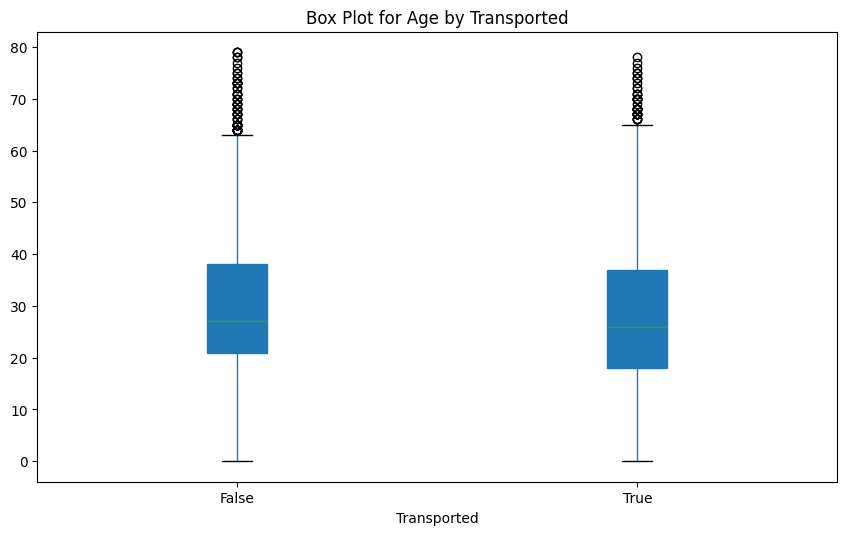

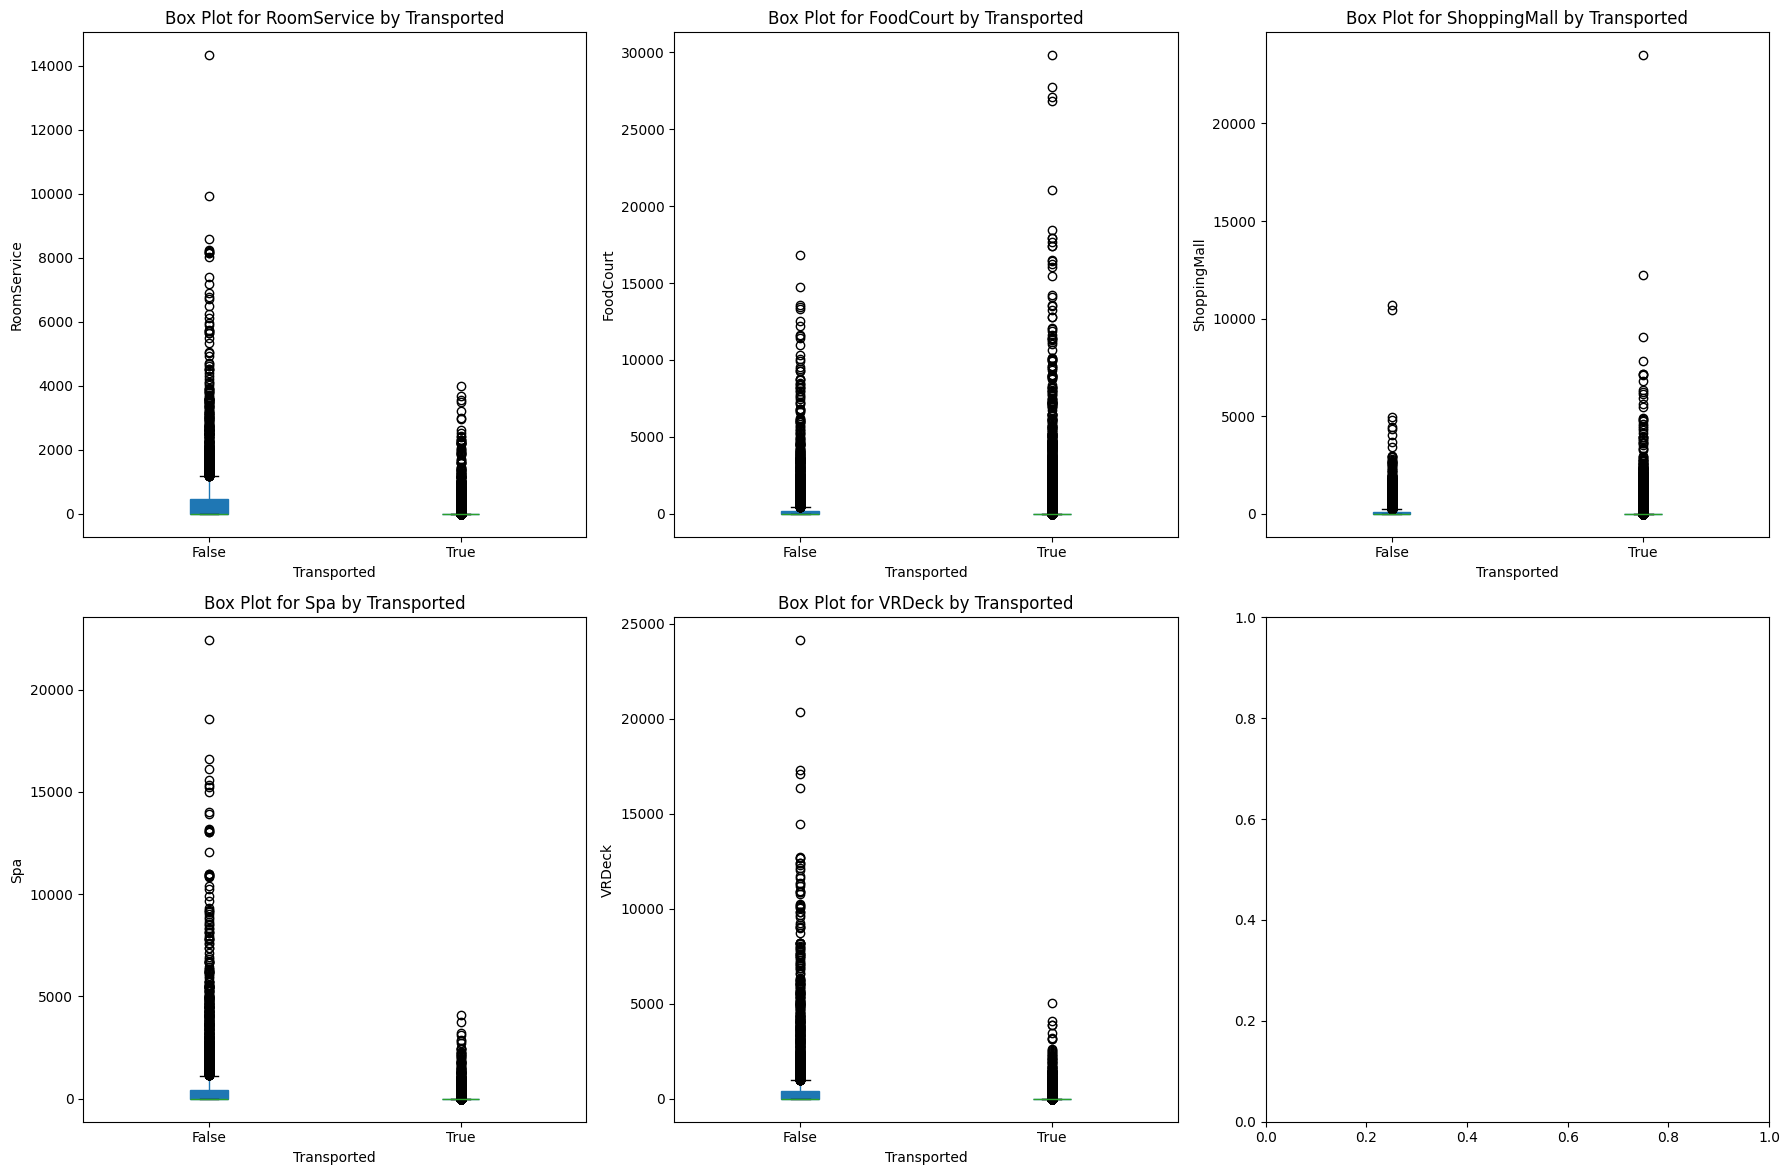

In [14]:
# Create side-by-side box plots for the Age column using pandas boxplot method
train_data.boxplot(column='Age', by=TARGET_COLUMN, figsize=(10
, 6), grid=False, patch_artist=True)
plt.title("Box Plot for Age by Transported")
plt.suptitle("")
plt.show()

# Create side-by-side box plots for the other numerical columns using pandas boxplot method
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
for i, col in enumerate(NUMERICAL_COLUMNS[1:]):
    ax = axes[i // 3, i % 3]
    train_data.boxplot(column=col, by=TARGET_COLUMN, ax=ax, grid=False, patch_artist=True)
    ax.set_title(f"Box Plot for {col} by {TARGET_COLUMN}")
    ax.set_xlabel(TARGET_COLUMN)
    ax.set_ylabel(col)
plt.suptitle("")
plt.tight_layout()
plt.show()

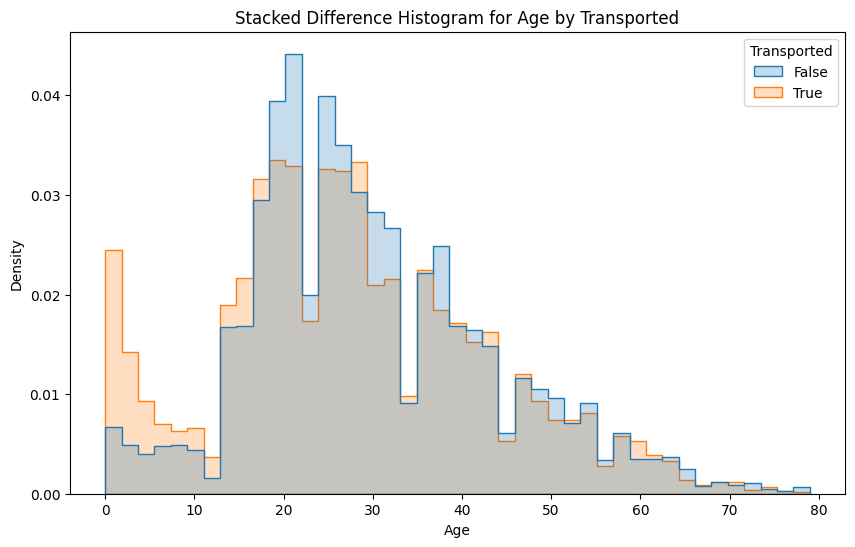

In [24]:
# Create a histogram for Age by Transported
plt.figure(figsize=(10, 6))

# Plot histograms for each class of Transported
sns.histplot(data=train_data, x='Age', hue=TARGET_COLUMN, element='step', stat='density', common_norm=False)

# Calculate the difference between the two histograms
age_transported = train_data[train_data[TARGET_COLUMN] == True]['Age'].dropna()
age_not_transported = train_data[train_data[TARGET_COLUMN] == False]['Age'].dropna()

# Create a difference plot
age_bins = np.histogram_bin_edges(train_data['Age'].dropna(), bins=30)
hist_transported, _ = np.histogram(age_transported, bins=age_bins, density=True)
hist_not_transported, _ = np.histogram(age_not_transported, bins=age_bins, density=True)
hist_difference = hist_transported - hist_not_transported

plt.title("Stacked Difference Histogram for Age by Transported")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

Número de valores atípicos por columna:
Age               77
RoomService     1861
FoodCourt       1823
ShoppingMall    1829
Spa             1788
VRDeck          1809
dtype: int64


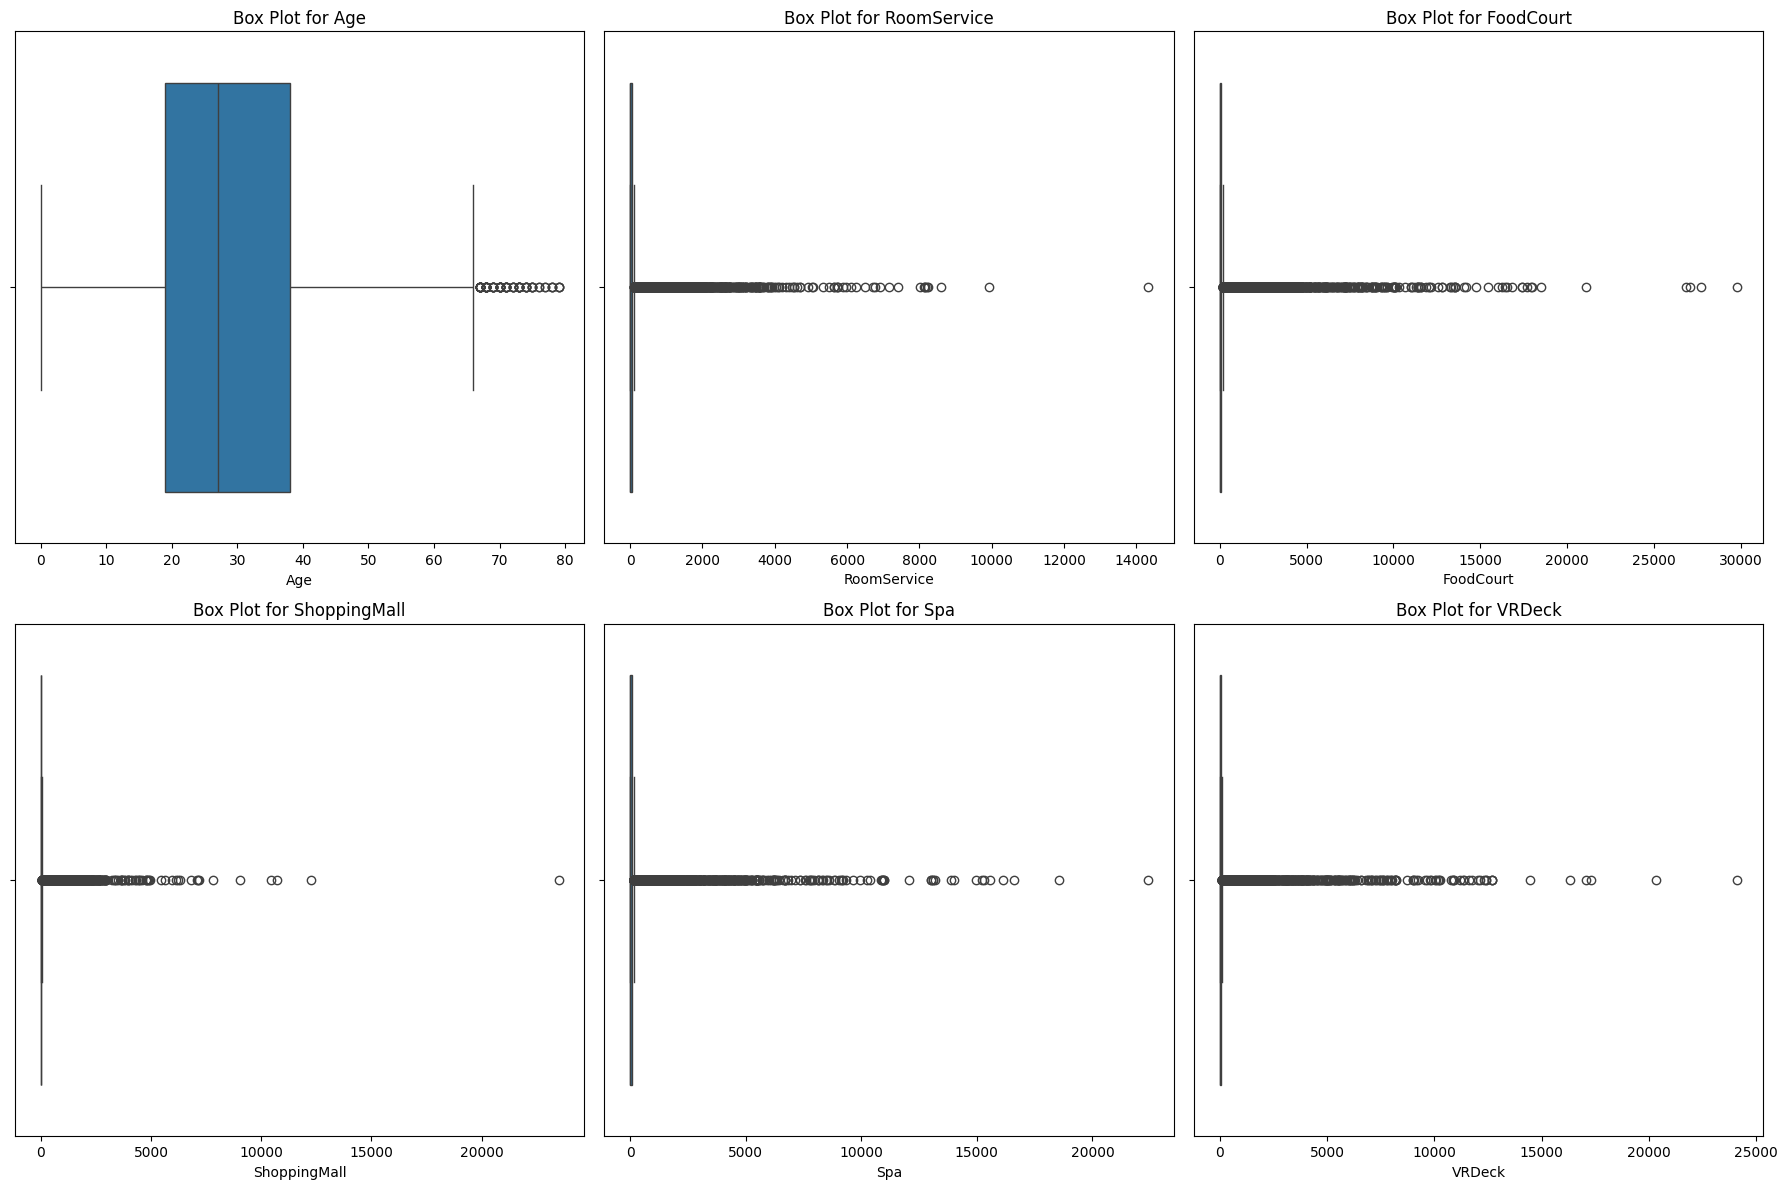

In [19]:
# Análisis de datos anómalos

# Función para detectar valores atípicos utilizando el método del rango intercuartílico (IQR)
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Detectar valores atípicos en las columnas numéricas
outliers = train_data[NUMERICAL_COLUMNS].apply(detect_outliers_iqr)

# Contar el número de valores atípicos por columna
outliers_count = outliers.sum()

print("Número de valores atípicos por columna:")
print(outliers_count)

# Visualizar los valores atípicos utilizando boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
for i, col in enumerate(NUMERICAL_COLUMNS):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=train_data[col], ax=ax)
    ax.set_title(f"Box Plot for {col}")
plt.tight_layout()
plt.show()

In [11]:
# Calculate the number of missing values per column
missing_values_count = train_data.isnull().sum()

# Calculate the percentage of missing values per column
missing_values_percentage = (missing_values_count / len(train_data)) * 100

# Combine the results into a DataFrame for better visualization
missing_values_df = pd.DataFrame({
    'Missing Values': missing_values_count,
    'Percentage': missing_values_percentage
})

print("Number of missing values per column and their percentage:")
display(missing_values_df)

Number of missing values per column and their percentage:


,Missing Values,Percentage
PassengerId,0,0.000000
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Cabin,199,2.289198
Destination,182,2.093639
Age,179,2.059128
VIP,203,2.335212
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730


In [12]:
print("\nSummary statistics:")
display(train_data.describe())

print("\nMissing values:")
print(train_data.isnull().sum())

# print("\nCorrelation matrix:")
# sns.heatmap(train_data[NUMERICAL_COLUMNS].corr(), annot=True)
# plt.show()

print("\nValue counts for categorical variables:")
for col in CATEGORICAL_COLUMNS:
    print(f"\n{col} value counts:")
    print(train_data[col].value_counts())


Summary statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8494.0
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,600.367671
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,167.25
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,427.0
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,999.0
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.0



Missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
CabinDeck       199
CabinNumber     199
CabinSide       199
dtype: int64

Value counts for categorical variables:

PassengerId value counts:
PassengerId
9280_02    1
0001_01    1
0002_01    1
0003_01    1
0003_02    1
          ..
0008_01    1
0007_01    1
0006_02    1
0006_01    1
0005_01    1
Name: count, Length: 8693, dtype: int64

HomePlanet value counts:
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

CryoSleep value counts:
CryoSleep
False    5439
True     3037
Name: count, dtype: int64

Cabin value counts:
Cabin
G/734/S     8
B/11/S      7
F/1411/P    7
B/82/S      7
G/981/S     7
           ..
G/543/S     1
B/106/P     1
G/542/S     1
F/700/P     1
G/5

In [13]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinNumber,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


## Clean Dataset

We need to clean the train and test datasets the same way


In [14]:
def clean_data(data: pd.DataFrame):

    data = data.copy()

    # Convert columns to integer (with missing values)
    for col in [
        "CabinNumber",
        "CryoSleep",
        "VIP",
        "Transported",
        "PassengerGroupId",
        "PassengerIntraGroupId",
    ]:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce").astype("Int64")

    # Make PassengerId the index
    data.set_index(ID_COLUMN, inplace=True)

    # Drop columns
    for col in [
        "Name",
        "Cabin",
        "PassengerGroupId",
        "PassengerIntraGroupId",
    ]:
        if col in data.columns:
            data.drop(columns=col, inplace=True)

    return data

In [15]:
# train_data = clean_data(train_data)
# test_data = clean_data(test_data)

## Create Features


In [16]:
CREATED_FEATURES = [
    "AmountSpentTotal",
    "CabinDeck",
    "CabinNumber",
    "CabinSide",
    "CabinMates",
    "PassengerGroupSize",
]


def create_features(
    data: pd.DataFrame,
    **kwargs,
):

    # Create new features:
    # - AmountSpentTotal: Total money spent in the ship's service
    # - CabinDeck: Deck of the cabin
    # - CabinNumber: Number of the cabin
    # - CabinSide: Side of the cabin
    # - CabinMates: Number of people in the same cabin
    # - PassengerGroupSize: Group Size

    # Get from kwargs the features to return
    selected_features = [
        feature for feature in CREATED_FEATURES if kwargs.get(f"use_{feature}", False)
    ]

    new_data = data.copy()
    data = data.copy()

    # Create new feature: Total money spent in the ship's service
    new_data["AmountSpentTotal"] = data[
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    ].sum(axis=1, skipna=True)

    # Create new feature: Mean money spent in the ship's service
    # TODO is the same as the other one
    # new_data["AmountSpentMean"] = data[
    #     ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    # ].mean(axis=1, skipna=True)

    # Create new features: Convert Cabin to three different columns (Deck, Number, Side)
    new_data[["CabinDeck", "CabinNumber", "CabinSide"]] = data["Cabin"].str.split(
        "/", expand=True
    )

    # Create new feature: Number of people in the same cabin
    new_data["CabinMates"] = data.groupby("Cabin")["Cabin"].transform("count")

    # Create new features: Group Id, Group Size, Intra Group Id,
    new_data[["PassengerGroupId", "PassengerIntraGroupId"]] = data[ID_COLUMN].str.split(
        "_", expand=True
    )
    new_data["PassengerGroupSize"] = new_data.groupby("PassengerGroupId")[
        "PassengerGroupId"
    ].transform("count")

    # Only return the old features and the selected new ones
    return pd.concat([data, new_data[selected_features]], axis=1)

In [17]:
# train_data = create_features(train_data)
# test_data = create_features(test_data)

In [18]:
pipeline = Pipeline(
    [
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
    ]
)

In [19]:
train_data_transformed_df = pipeline.fit_transform(train_data)
print(train_data_transformed_df.dtypes)

HomePlanet       object
CryoSleep         Int64
Destination      object
Age             float64
VIP               Int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported       Int64
CabinDeck        object
CabinNumber       Int64
CabinSide        object
dtype: object


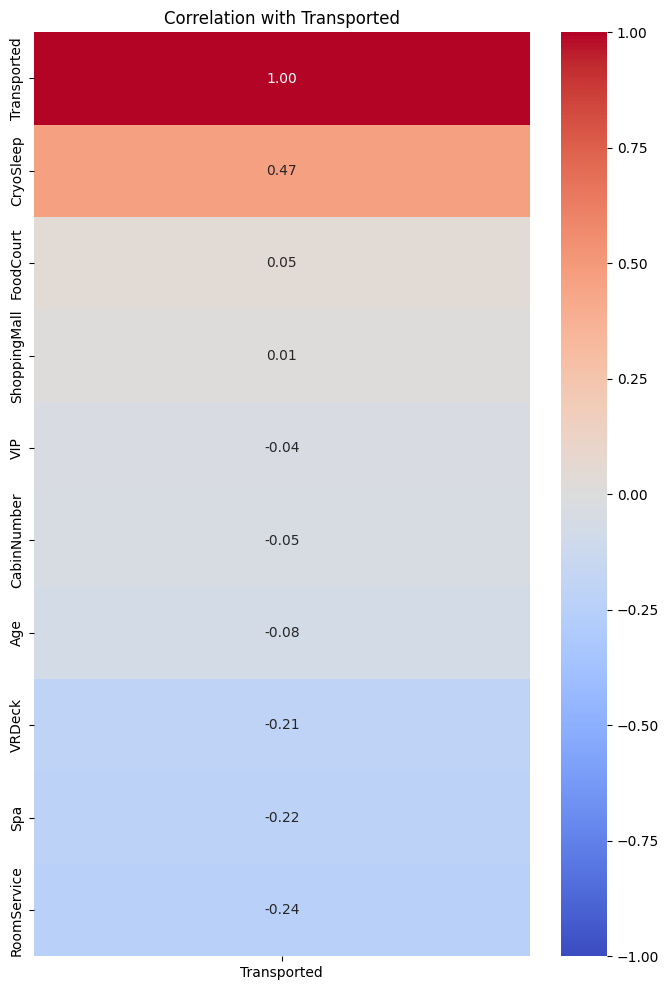

In [23]:
# Filter the dataframe to include only numerical columns
numerical_data = train_data_transformed_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Filter the correlation matrix to only include the Target Column
target_corr_matrix = corr_matrix[[TARGET_COLUMN]].sort_values(
    by=TARGET_COLUMN, ascending=False
)

plt.figure(figsize=(8, 12))
sns.heatmap(target_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlation with {TARGET_COLUMN}")
plt.show()

## Data Preprocessing Pipeline

### Handle Missing Values

- Input Data
- Mark as "Missing"

### Data Preprocessing

- Make Categorical Columns Numerical
  - One-Hot encoding
  - Ordinal encoding
- Scale Numerical Columns


In [19]:
MAX_CARDINALITY = 4


def select_high_cardinality_categorical_features(df: pd.DataFrame):
    hi_c_cat = df.select_dtypes(include=["object"]).nunique() > MAX_CARDINALITY
    features = hi_c_cat[hi_c_cat].index.tolist()
    return features


def select_low_cardinality_categorical_features(df: pd.DataFrame):
    lo_c_cat = df.select_dtypes(include=["object"]).nunique() <= MAX_CARDINALITY
    features = lo_c_cat[lo_c_cat].index.tolist()
    return features


def select_numerical_features(df: pd.DataFrame):
    return df.select_dtypes(include=[np.number]).columns.tolist()


# Combine handling missing values and preprocessing into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat_low_cardinality",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # SimpleImputer(strategy="most_frequent"),
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                    ),
                    (
                        "to_num",
                        OneHotEncoder(),
                        # OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            select_low_cardinality_categorical_features,  # make_column_selector(dtype_include='object'),
        ),
        (
            "cat_high_cardinality",
            Pipeline(
                steps=[
                    (
                        "impute",
                        SimpleImputer(strategy="constant", fill_value=MISSING_VALUE),
                        # SimpleImputer(strategy="most_frequent"),
                    ),
                    (
                        "to_num",
                        # OneHotEncoder(),
                        OrdinalEncoder(),
                        # LabelEncoder(),
                    ),
                ]
            ),
            select_high_cardinality_categorical_features,  # make_column_selector(dtype_include='object'),
        ),
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "impute",
                        # KNNImputer(n_neighbors=1),
                        # KNNImputer(n_neighbors=3),
                        KNNImputer(n_neighbors=5),
                        # SimpleImputer(strategy="mean"),
                        # SimpleImputer(strategy="median"),
                    ),
                    (
                        "scale",
                        StandardScaler(),
                        # MinMaxScaler(),
                        # RobustScaler(),
                    ),
                ]
            ),
            select_numerical_features,  # make_column_selector(dtype_include='number'),
        ),
    ],
    remainder="passthrough",
    # sparse_threshold=0,
)

# preprocessor.set_output(transform="pandas")

In [20]:
pipeline = Pipeline(
    steps=[
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
        ("preprocessor", preprocessor),
    ]
)

In [21]:
def transform_data(data: pd.DataFrame, pipeline: Pipeline) -> pd.DataFrame:
    X = data.drop(columns=[TARGET_COLUMN])
    y = data[TARGET_COLUMN]

    # Fit and transform the data using the pipeline
    data_transformed = pipeline.fit_transform(X=X, y=y)

    # Extract feature names from the preprocessor step
    if "preprocessor" in pipeline.named_steps:
        feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    else:
        feature_names = data.columns

    # Extract the selected feature indices from the feature engineering step
    if "feature_engineering" in pipeline.named_steps:
        feature_selector = pipeline.named_steps["feature_engineering"].named_steps[
            "feature_selection"
        ]
        if isinstance(feature_selector, SelectFromModel):
            support_mask = feature_selector.get_support()
        elif isinstance(feature_selector, RFE):
            support_mask = feature_selector.support_
        else:
            support_mask = np.ones(len(feature_names), dtype=bool)
        selected_feature_names = [
            name for name, selected in zip(feature_names, support_mask) if selected
        ]
    else:
        selected_feature_names = feature_names

    # Remove prefixes from the column names
    selected_feature_names = [name.split("__")[-1] for name in selected_feature_names]

    # Convert the transformed data back to a DataFrame
    data_transformed_df = pd.DataFrame(data_transformed, columns=selected_feature_names)

    data_transformed_df[TARGET_COLUMN] = y.values

    return data_transformed_df

In [22]:
# Use the function to transform the train_data
train_data_transformed_df = transform_data(train_data, pipeline)

### Check Preprocessing Works

- Check if no missing values after preprocessing
- Check if all columns are numerical after preprocessing


In [23]:
# Check for missing values

print("Number of missing values in transformed data:")
display(pd.DataFrame(train_data_transformed_df.isna().sum()).T)

assert train_data_transformed_df.isna().sum().sum() == 0

Number of missing values in transformed data:


,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinSide_Missing,CabinSide_P,...,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,Transported
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Check all columns are numerical

all_columns_numerical = train_data_transformed_df.select_dtypes(
    include=[np.number]
).columns.tolist()
all_columns = train_data_transformed_df.columns.tolist()

columns_not_numerical = (
    set(all_columns) - set(all_columns_numerical) - set([TARGET_COLUMN])
)
print(f"Columns not numerical: {columns_not_numerical}")

# Output the types of the non-numerical columns
for col in columns_not_numerical:
    print(
        f"Column: {col}, Type: {train_data_transformed_df[col].dtype}, First Value: {train_data_transformed_df[col].iloc[0]}"
    )

assert columns_not_numerical == set()

Columns not numerical: set()


## Feature Engineering


In [25]:
feature_engineering = Pipeline(
    steps=[
        # ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
        # ("feature_selection", RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED))),
        # ("feature_selection", RFE(estimator=RandomForestClassifier(random_state=RANDOM_SEED), n_features_to_select=10)),
        (
            "feature_selection",
            SelectFromModel(LassoCV(cv=5, random_state=RANDOM_SEED, max_iter=10000)),
        ),
        # ("feature_selection", SelectKBest(f_classif, k=10)),
        # ("feature_selection", SelectKBest(mutual_info_classif, k=10)),
        # ("feature_selection", SelectKBest(f_classif, k=20)),
        # ("feature_selection", SelectKBest(mutual_info_classif, k=20)),
        # ("feature_selection", SelectFromModel(RandomForestClassifier(random_state=RANDOM_SEED), threshold="mean")),
    ]
)

In [26]:
# Add the feature engineering pipeline to the main pipeline
pipeline = Pipeline(
    steps=[
        ("create_features", FunctionTransformer(create_features)),
        ("clean_data", FunctionTransformer(clean_data)),
        ("preprocessor", preprocessor),
        ("feature_engineering", feature_engineering),
    ]
)

In [27]:
# Use the function to transform the train_data
train_data_transformed_df = transform_data(train_data, pipeline)

In [28]:
train_data_transformed_df.columns

Index(['HomePlanet_Earth', 'HomePlanet_Europa', 'Destination_55 Cancri e',
       'Destination_TRAPPIST-1e', 'CabinSide_P', 'CabinSide_S', 'CabinDeck',
       'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'CabinNumber', 'Transported'],
      dtype='object')

## Analyze Correlation on Transformed Dataset


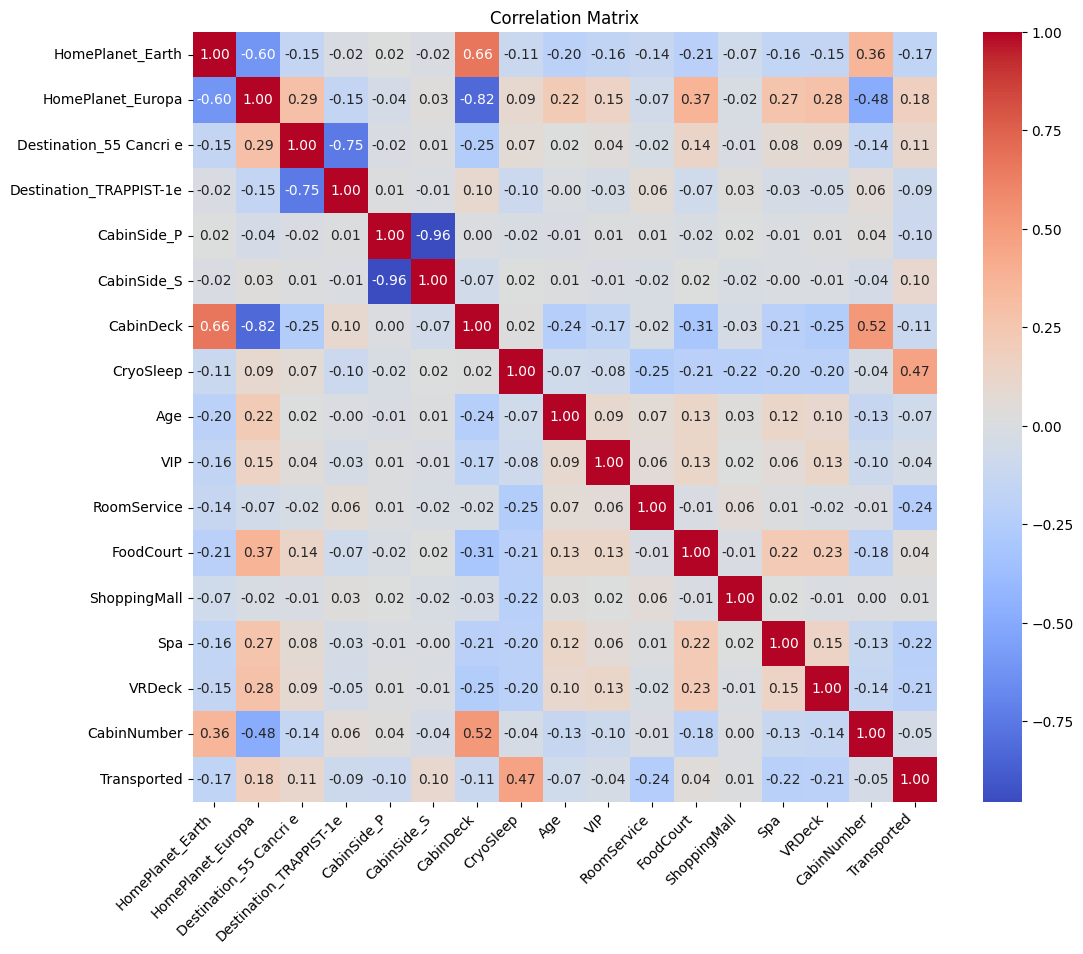

In [29]:
corr_matrix = train_data_transformed_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    xticklabels=train_data_transformed_df.columns.tolist(),
    yticklabels=train_data_transformed_df.columns.tolist(),
)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

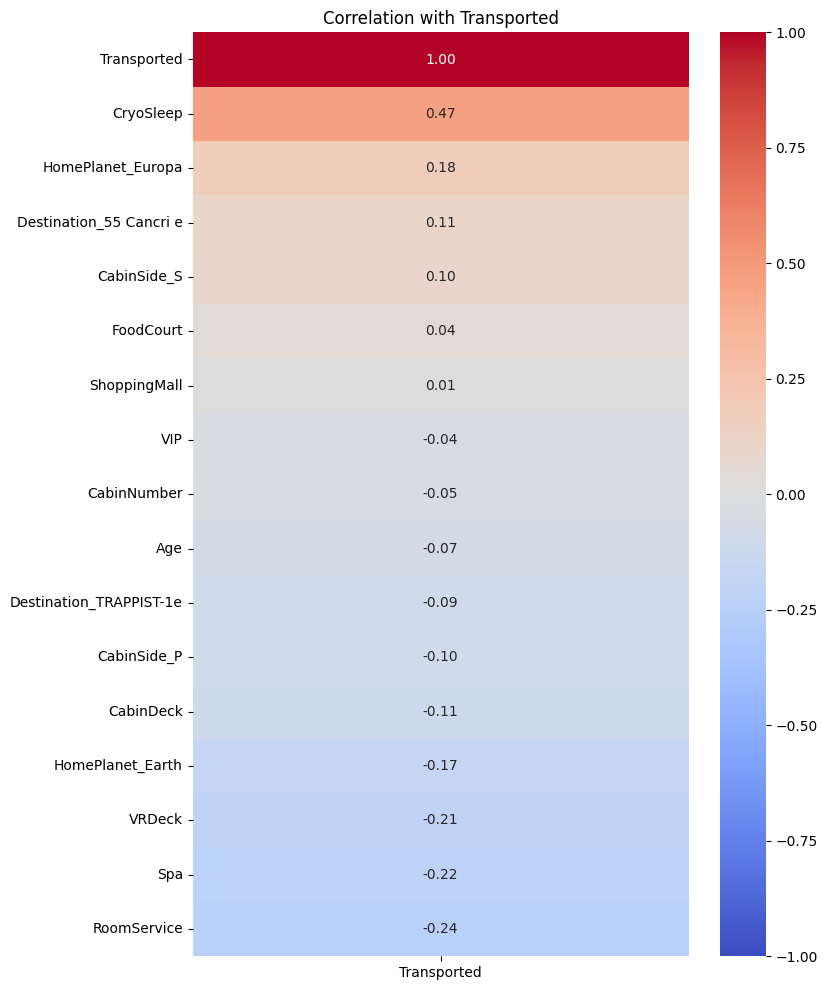

In [30]:
# Filter the correlation matrix to only include the Target Column
target_corr_matrix = corr_matrix[[TARGET_COLUMN]].sort_values(
    by=TARGET_COLUMN, ascending=False
)

plt.figure(figsize=(8, 12))
sns.heatmap(target_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlation with {TARGET_COLUMN}")
plt.show()